# Import



In [1]:
### Import des bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd

### Configuration des options pour les graphiques
%matplotlib inline
sns.set(style="whitegrid")


## Merged data

In [2]:

### Charger les datasets
# dataframe depuis kaggle
heart_data_1 = pd.read_csv('../heart_disease_uci.csv')
# dataframe depuis source
heart_data_2 = pd.read_csv('../HeartDiseaseUCI.csv')

### Afficher un aperçu des données
display(heart_data_1.head())
display(heart_data_2.head())

id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0

Unnamed: 0  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0           1   63    1   1       145   233    1        2      150      0   
1           2   67    1   4       160   286    0        2      108      1   
2           3   67    1   4       120   229    0        2      129      1   
3           4   37    1   3       130   250    0        0      187      0   
4           5   41    0   2       130   204    0        2      172      0   

   oldpeak  slope   ca  thal  num  
0      2.3      3  0.0   6.0    0  
1      1.5      2  3.0   3.0    2  
2      2.6      2  2.0   7.0    1  
3      3.5      3  0.0   3.0    0  
4      1.4      1  0.0   3.0    0

In [3]:
print(f"heart data 1 shape{heart_data_1.shape}")
print(f"heart data 2 shape{heart_data_2.shape}")

heart data 1 shape(920, 16)
heart data 2 shape(303, 15)


In [4]:


# Step 1: Rename specific columns in heart_data_1 to match heart_data_2
# Renaming 'id' to 'Unnamed: 0' and 'thalch' to 'thalach'
heart_data_1 = heart_data_1.rename(columns={'id': 'Unnamed: 0', 'thalch': 'thalach'})

# Step 2: Define mappings for categorical variables
# Chest pain type (cp)
cp_mapping = {
    "typical angina": 1,
    "atypical angina": 2,
    "non-anginal": 3,
    "asymptomatic": 4
}

# Resting ECG results (restecg)
restecg_mapping = {
    "normal": 0,
    "lv hypertrophy": 1,
    "st-t abnormality": 2
}

# Slope of the peak exercise ST segment (slope)
slope_mapping = {
    "upsloping": 1,
    "flat": 2,
    "downsloping": 3
}

# Thalassemia (thal)
thal_mapping = {
    "normal": 3,
    "fixed defect": 6,
    "reversable defect": 7
}

# Mapping for sex
sex_mapping = {
    "Male": 1,
    "Female": 0
}

# Step 3: Apply mappings to transform heart_data_1
heart_data_1['cp'] = heart_data_1['cp'].map(cp_mapping)
heart_data_1['restecg'] = heart_data_1['restecg'].map(restecg_mapping)
heart_data_1['slope'] = heart_data_1['slope'].map(slope_mapping)
heart_data_1['thal'] = heart_data_1['thal'].map(thal_mapping)
heart_data_1['sex'] = heart_data_1['sex'].map(sex_mapping)

# Step 4: Convert boolean columns to integers (0 and 1)
heart_data_1['fbs'] = heart_data_1['fbs'].astype(float)
heart_data_1['exang'] = heart_data_1['exang'].astype(float)

# Step 5: Ensure columns in heart_data_1 match the columns in heart_data_2
heart_data_1 = heart_data_1[heart_data_2.columns]

# Step 6: Merge the two DataFrames and drop duplicates
merged_df = pd.concat([heart_data_1, heart_data_2], ignore_index=True)
merged_df = merged_df.drop_duplicates()

# Display the first few rows of the merged DataFrame
print(merged_df.head())


   Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   oldpeak  slope   ca  thal  num  
0      2.3    3.0  0.0   6.0    0  
1      1.5    2.0  3.0   3.0    2  
2      2.6    2.0  2.0   7.0    1  
3      3.5    3.0  0.0   3.0    0  
4      1.4    1.0  0.0   3.0    0  


### Explication rapide des colonnes et valeurs

Unnamed: 0 : Identifiant unique de chaque observation.
age : Âge du patient.
sex : Sexe du patient (1 = Homme, 0 = Femme).
cp : Type de douleur thoracique (chest pain type) :

    1 : Angine typique
    2 : Angine atypique
    3 : Douleur non angineuse
    4 : Asymptomatique

trestbps : Pression artérielle au repos en mm Hg.
chol : Niveau de cholestérol sérique en mg/dl.
fbs : Glycémie à jeun > 120 mg/dl (1 = Vrai ; 0 = Faux).
restecg : Résultats de l'électrocardiogramme au repos :

    0 : Normal
    1 : Hypertrophie ventriculaire gauche (lv hypertrophy)
    2 : Anomalie de ST-T

thalach : Fréquence cardiaque maximale atteinte.
exang : Angine induite par l'exercice (1 = Oui ; 0 = Non).
oldpeak : Dépression de ST induite par l'exercice par rapport au repos.
slope : Pente du segment ST lors du pic d'exercice :

    1 : Pente montante (upsloping)
    2 : Pente plate (flat)
    3 : Pente descendante (downsloping)

ca : Nombre de vaisseaux principaux (0-3) colorés par fluoroscopie.
thal : Résultats du test thalium :

    3 : Normal
    6 : Défaut fixe (fixed defect)
    7 : Défaut réversible (reversable defect)

num : Indicateur de présence de maladie cardiaque (0 = Absence ; 1-4 = Présence).

In [5]:
merged_df.shape

(1072, 15)

Valeurs manquantes par colonne :
 Unnamed: 0      0
age             0
sex             0
cp              0
trestbps       59
chol           30
fbs            90
restecg         2
thalach        55
exang          55
oldpeak        62
slope         309
ca            612
thal          487
num             0
dtype: int64

Statistiques descriptives :
        Unnamed: 0          age          sex           cp     trestbps  \
count  1072.000000  1072.000000  1072.000000  1072.000000  1013.000000   
mean    415.123134    53.843284     0.774254     3.247201   132.465943   
std     272.047326     9.356996     0.418268     0.939581    18.965125   
min       1.000000    28.000000     0.000000     1.000000     0.000000   
25%     172.750000    47.750000     1.000000     3.000000   120.000000   
50%     384.500000    55.000000     1.000000     4.000000   130.000000   
75%     652.250000    60.000000     1.000000     4.000000   140.000000   
max     920.000000    77.000000     1.000000     4.000000   20

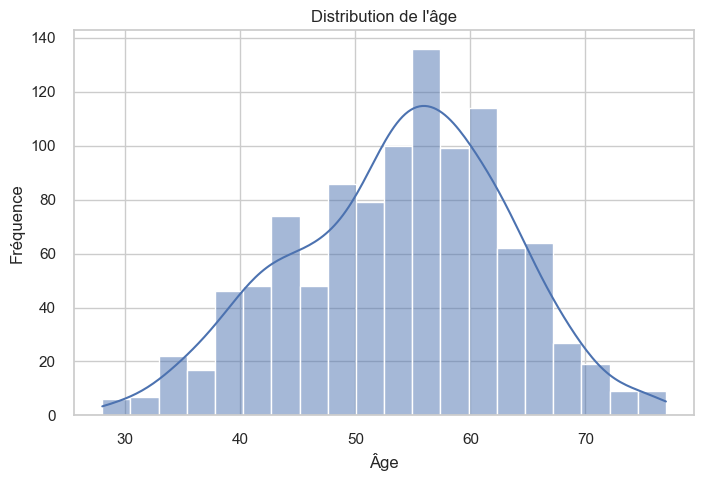

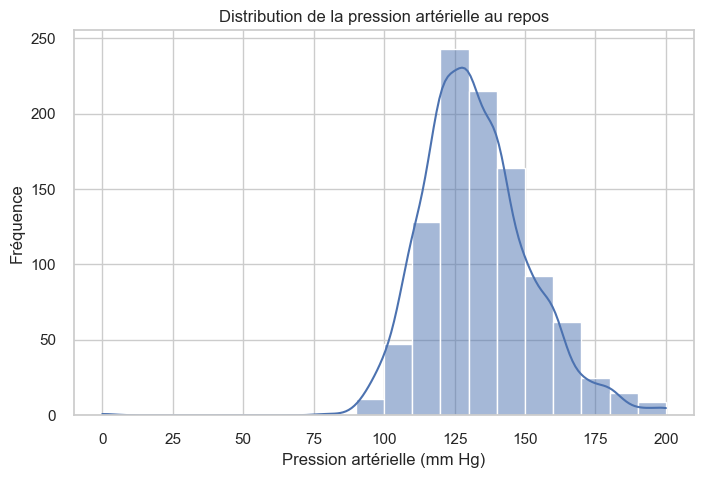

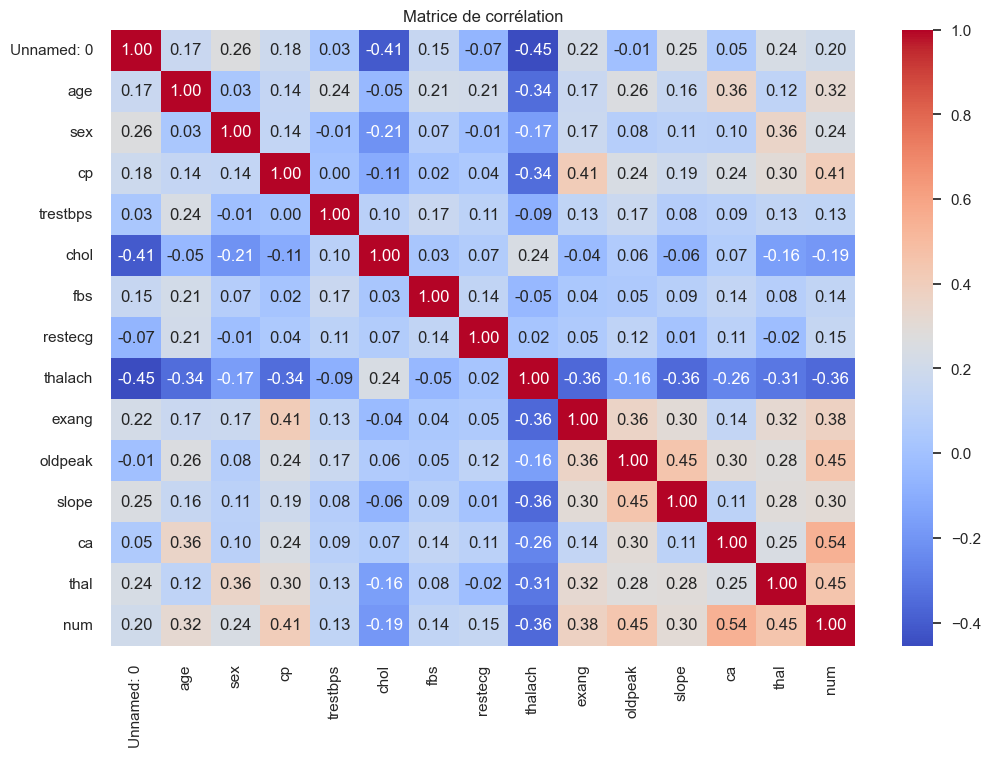

In [6]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :\n", merged_df.isnull().sum())

# Afficher les statistiques descriptives
print("\nStatistiques descriptives :")
print(merged_df.describe())

# Visualiser la distribution de l'âge
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la distribution de la pression artérielle au repos
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['trestbps'], bins=20, kde=True)
plt.title("Distribution de la pression artérielle au repos")
plt.xlabel("Pression artérielle (mm Hg)")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la corrélation entre les variables
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

### Plotting


#### Numérique


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Configuration de la grille de plots pour les distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(merged_df[col], kde=True, bins=20)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

 #### Catégoritielle

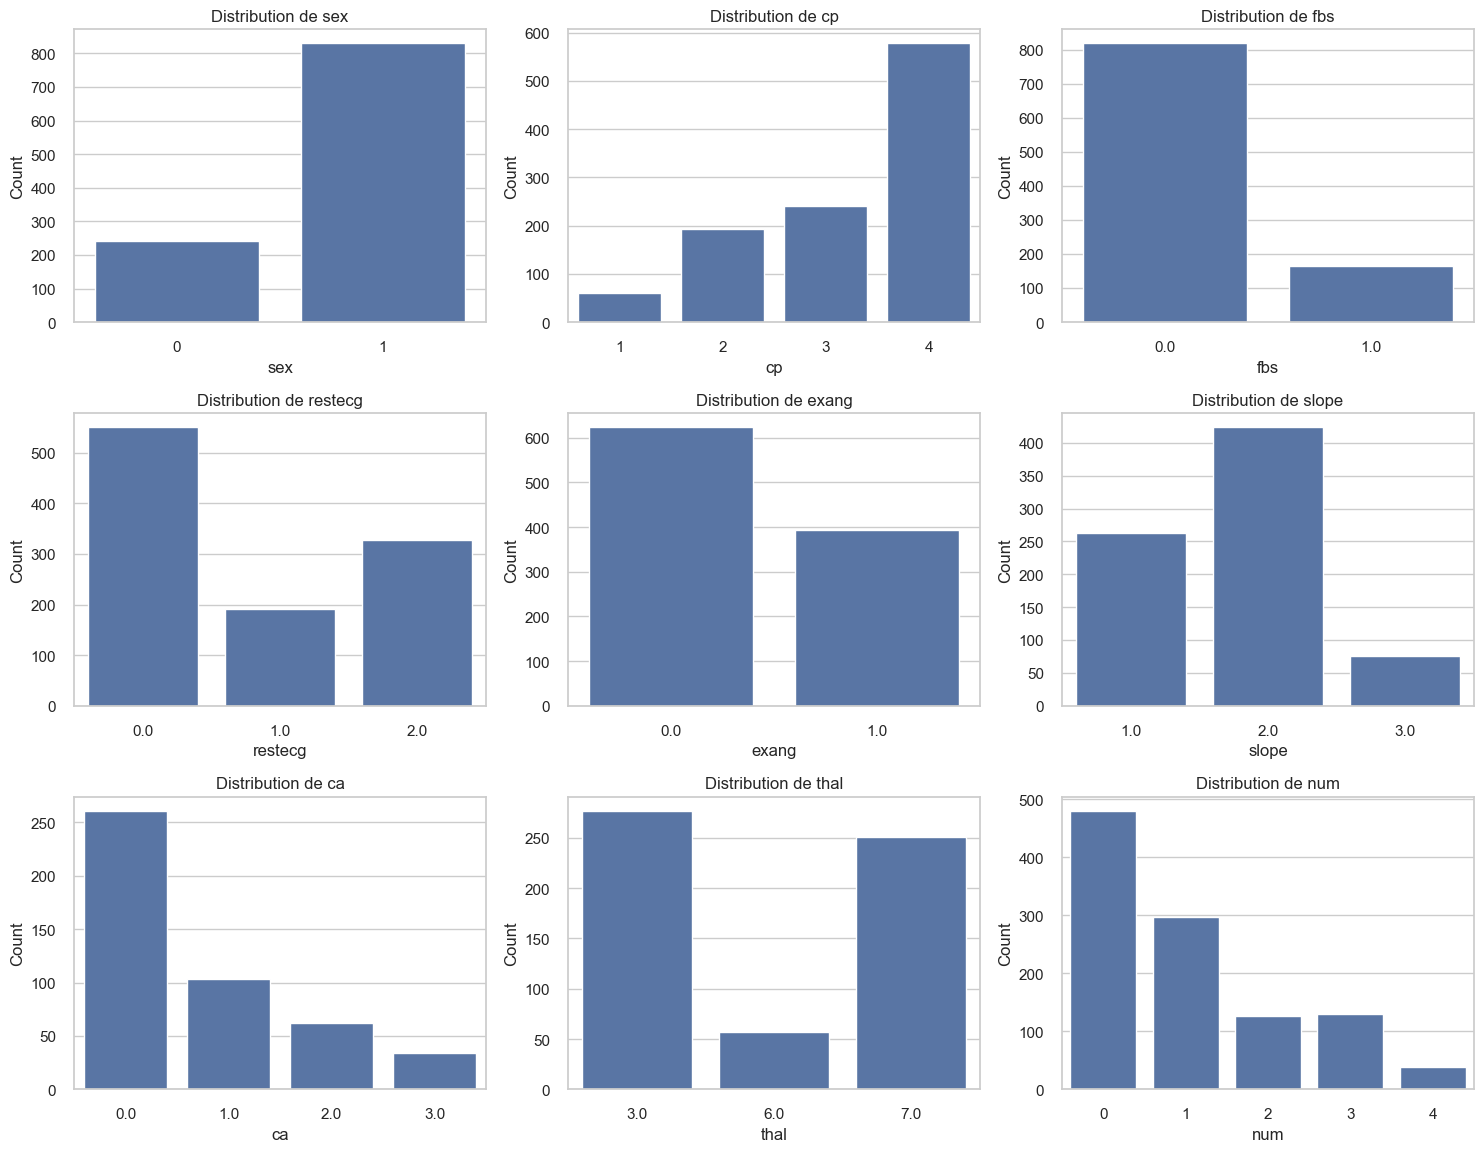

In [ ]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

# Configuration de la grille de plots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Analyse Bivarié

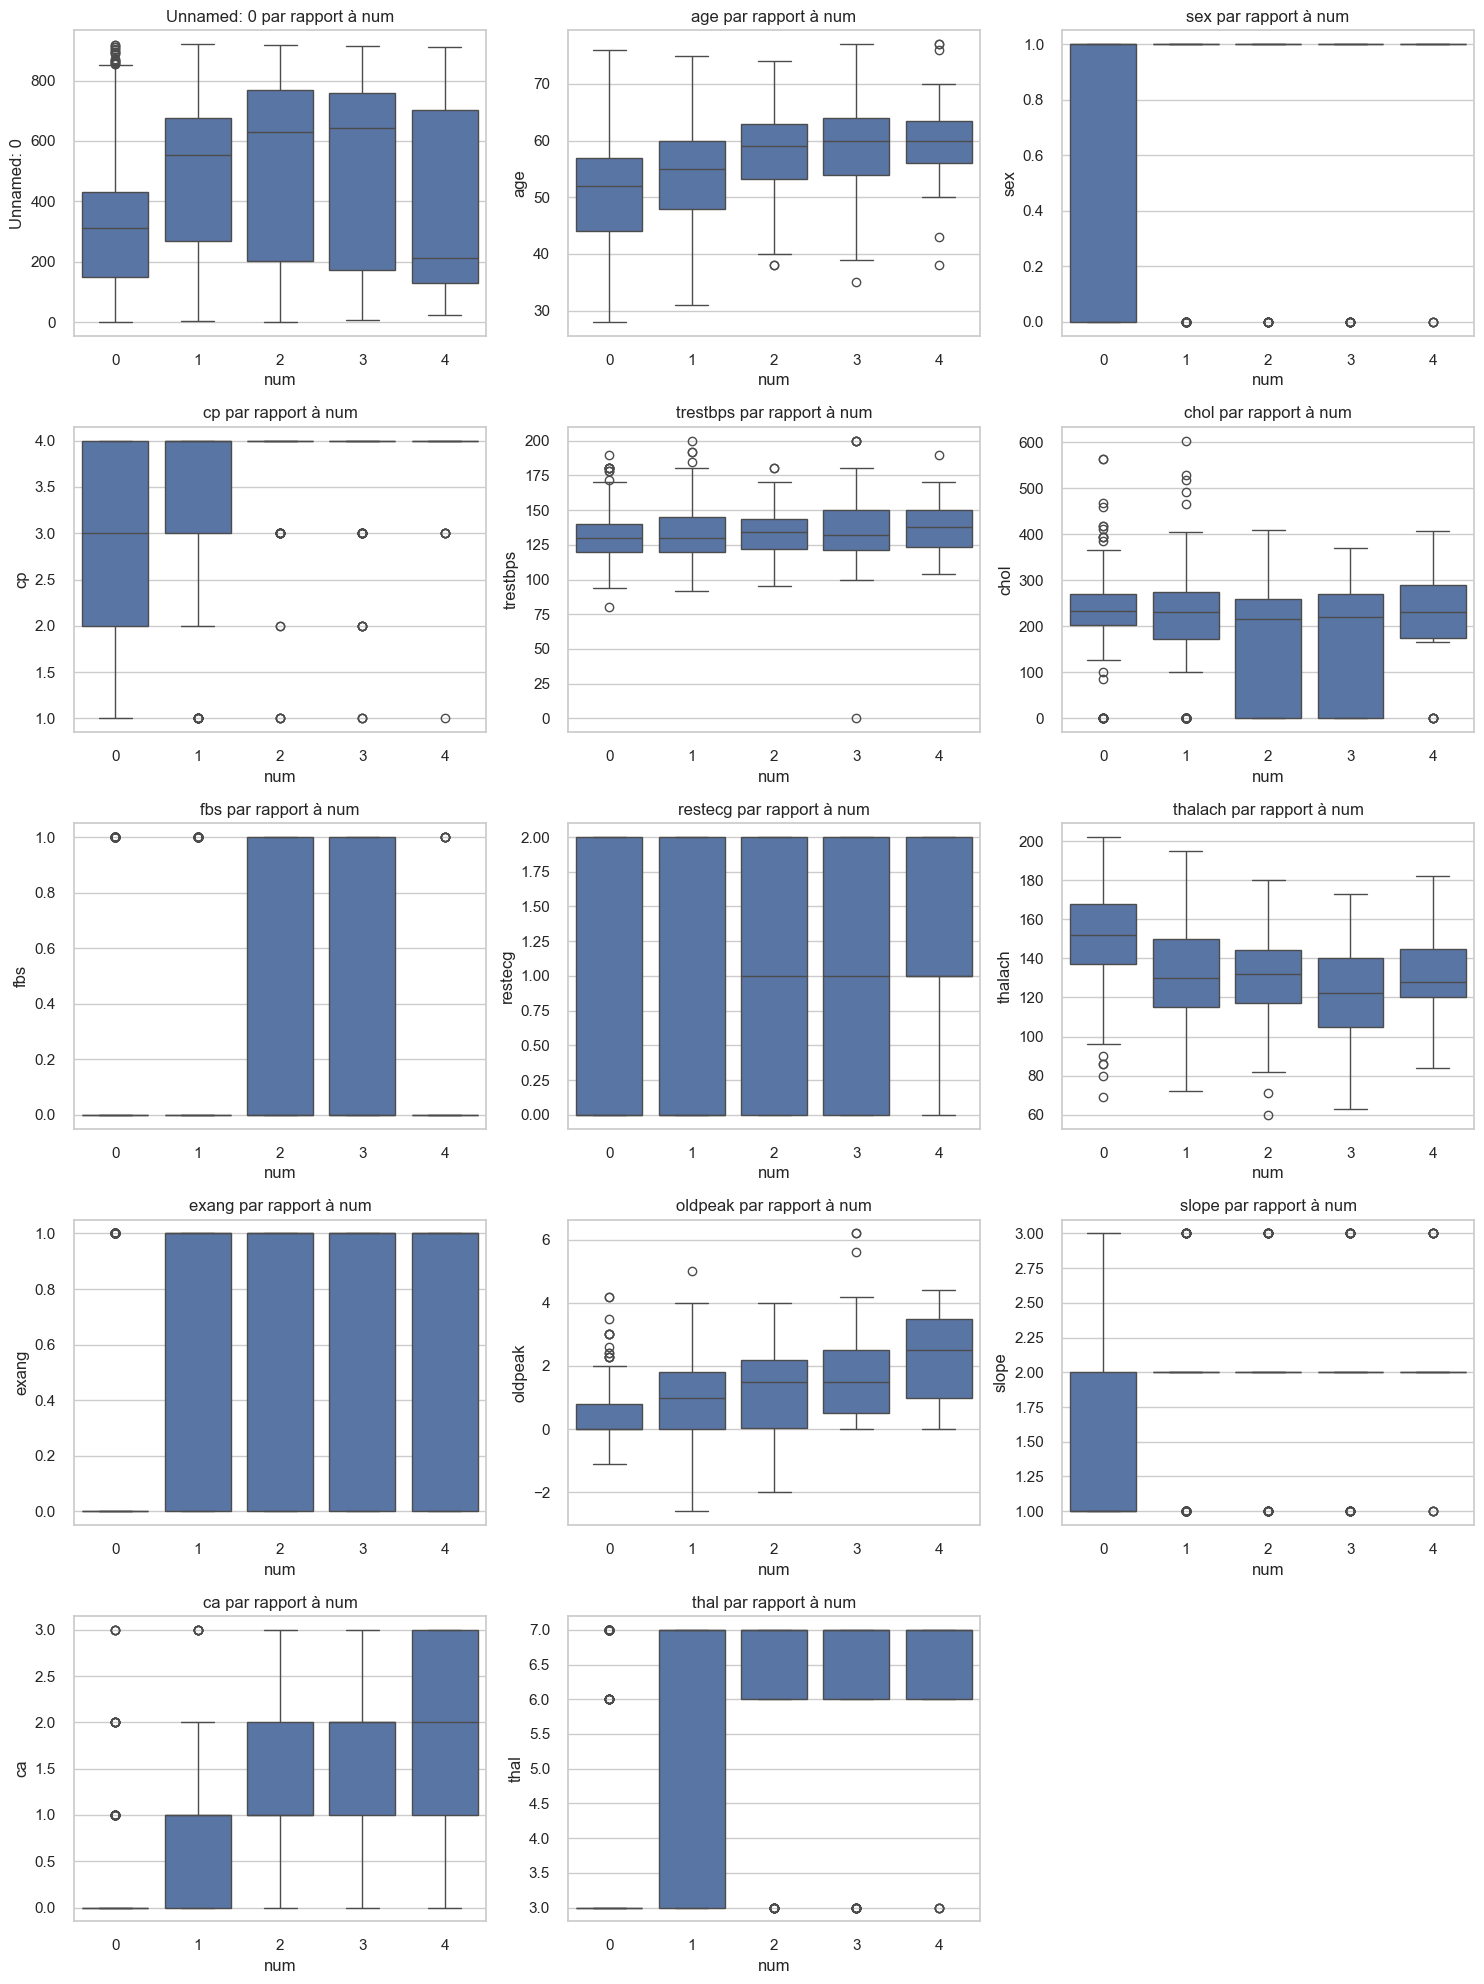

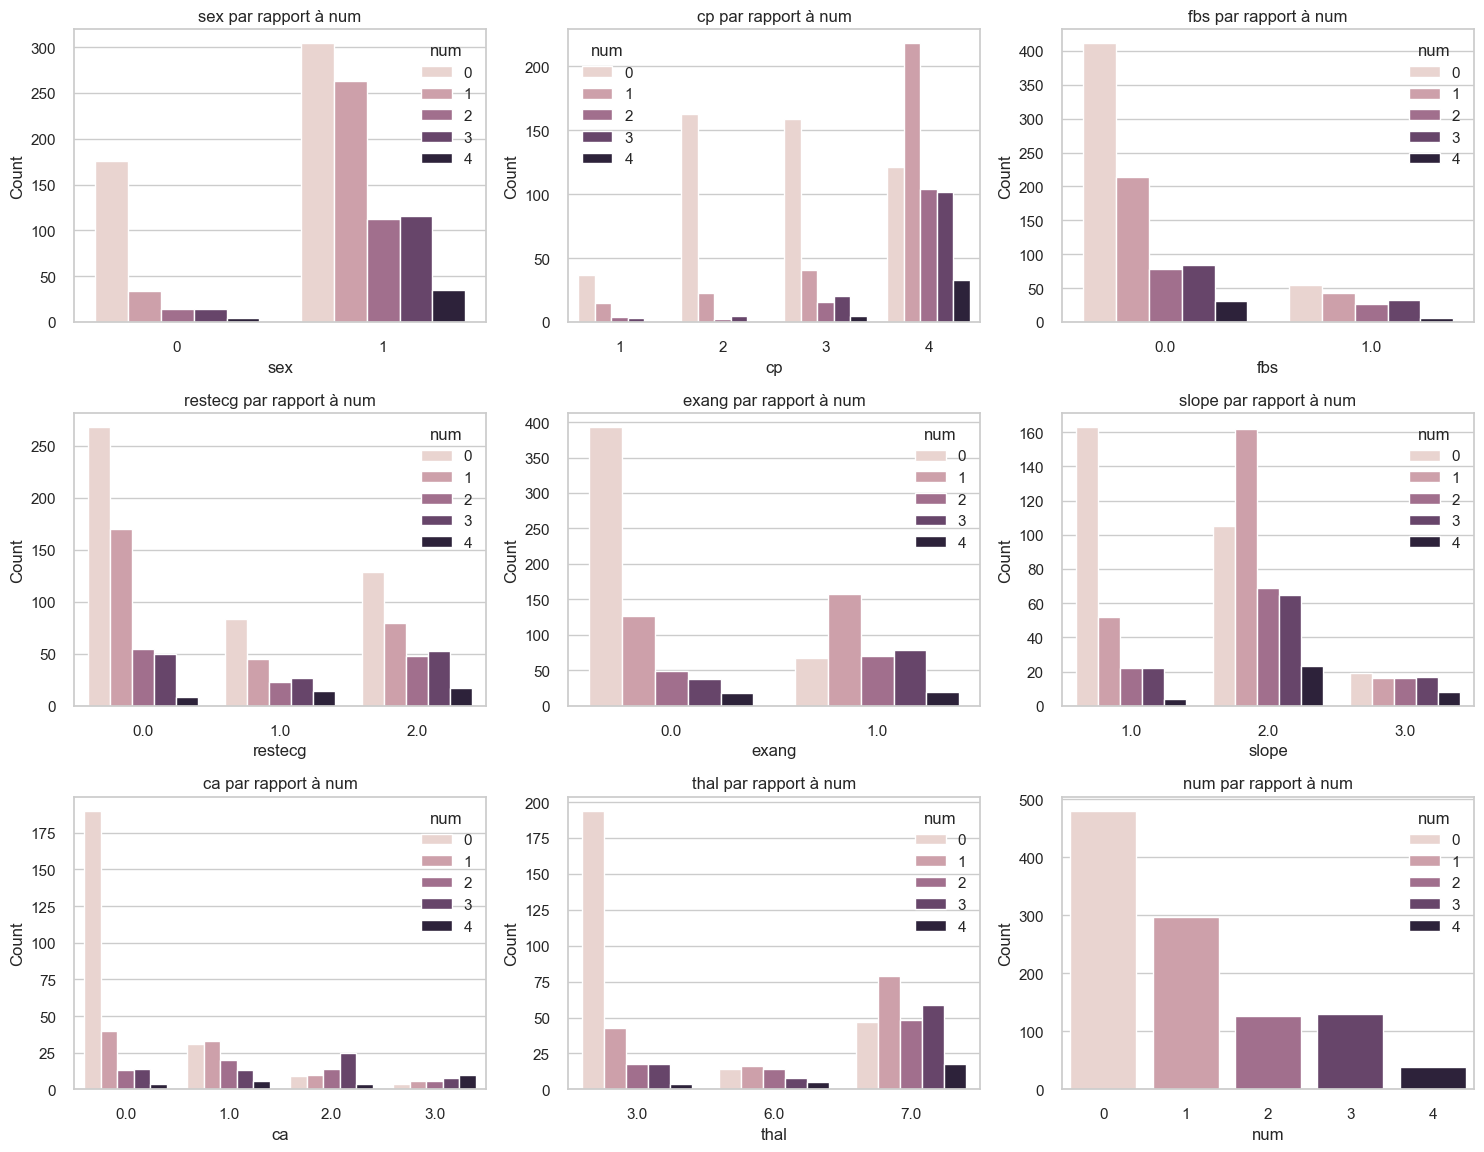

In [ ]:
# Analyse bivariée avec la variable cible `num`
target_column = 'num'
numeric_features = merged_df.select_dtypes(include=['float64', 'int64']).columns.drop(target_column)

# Visualisation des variables numériques par rapport à la cible avec des boxplots
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features) // 3 + 1, 3, i)
    sns.boxplot(data=merged_df, x=target_column, y=col)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(target_column)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Visualisation des variables catégorielles par rapport à la cible avec des countplots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col, hue=target_column)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Suite à l'observation : traitement des données

In [ ]:
merged_df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps      float64
chol          float64
fbs           float64
restecg       float64
thalach       float64
exang         float64
oldpeak       float64
slope         float64
ca            float64
thal          float64
num             int64
dtype: object

### Transforme data

Choix de l'imputation et du scaler:

L'imputation KNN a été choisi afin de conserver la distribution ainsi que la relation entre les colonnes. en effet, nous nous basons sur la positions des points dans l'espace et la distance entre ces derniers: cela est la stratégie adaptée car les disstributions ne respectent pas la loi Gaussienne

RobustScaler est préféré dans ce contexte parce qu’il est moins sensible aux valeurs extrêmes (outliers). Contrairement à StandardScaler, qui utilise la moyenne et l’écart-type, RobustScaler se base sur la médiane et les quartiles. Cela permet d'avoir une distribution normalisée tout en réduisant l'impact des valeurs anormalement élevées ou basses, ce qui est pertinent pour des variables comme chol ou oldpeak, qui peuvent présenter des valeurs extrêmes.

Cette préparation rend les données homogènes et prêtes pour une analyse de classification sans distorsion excessive due aux outliers.

In [ ]:
merged_df

Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0              1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1              2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2              3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3              4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4              5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   
...          ...  ...  ...  ..       ...    ...  ...      ...      ...    ...   
1208         289   56    1   2     130.0  221.0  0.0      2.0    163.0    0.0   
1210         291   67    1   3     152.0  212.0  0.0      2.0    150.0    0.0   
1213         294   63    1   4     140.0  187.0  0.0      2.0    144.0    1.0   
1216         297   59    1   4     164.0  176.0  1.0      2.0     90.0    0.0   
1221         302   57    0   2     130.0  236.0  0.0      2.0    174.0    0.0   

      oldpeak  slope   ca  thal  num  
0         2.3    3.0  0.0   6.0    0  
1         1.5    2.0  3.0   3.0    2  
2         2.6    2.0  2.0   7.0    1  
3         3.5    3.0  0.0   3.0    0  
4         1.4    1.0  0.0   3.0    0  
...       ...    ...  ...   ...  ...  
1208      0.0    1.0  0.0   7.0    0  
1210      0.8    2.0  0.0   7.0    1  
1213      4.0    1.0  2.0   7.0    2  
1216      1.0    2.0  2.0   6.0    3  
1221      0.0    2.0  1.0   3.0    1  

[1072 rows x 15 columns]

## Feature Engineering

Suite à des recherches nous avons :

Valeurs de Référence Générales pour les Indicateurs Cardiaques

    Cholestérol Total :
        Seuil souhaitable : < 200 mg/dL
        Limite élevée : 200–239 mg/dL
        Niveau élevé : ≥ 240 mg/dL
        Note : Vous pourriez utiliser 200 mg/dL comme seuil pour le chol_ratio.

    Tension Artérielle au Repos (trestbps) :
        Normale : < 120 mm Hg (systolique) et < 80 mm Hg (diastolique)
        Hypertension stade 1 : 130–139 mm Hg (systolique) ou 80–89 mm Hg (diastolique)
        Hypertension stade 2 : ≥ 140 mm Hg (systolique) ou ≥ 90 mm Hg (diastolique)
        Valeur recommandée : Vous pouvez utiliser 120 mm Hg comme référence pour le trestbps_anomaly.

    Fréquence Cardiaque Maximale (thalach) :
        La fréquence cardiaque maximale dépend de l'âge, généralement estimée par la formule : 220 - âge.
        Exemple : pour un patient de 60 ans, la fréquence cardiaque maximale serait d'environ 160 battements par minute.
        Note : Vous pourriez normaliser la thalach en fonction de cette formule pour créer une variable standardisée.

    Score de Risque Cardiovasculaire (exemple simplifié) :
        Des scores tels que le score de Framingham existent pour prédire les risques à 10 ans en fonction de plusieurs facteurs (âge, cholestérol, tension, sexe, etc.).
        À défaut d'utiliser un score clinique spécifique, vous pouvez pondérer les valeurs comme suit :
            Age : 0.3
            Cholestérol : 0.3
            Tension au repos (trestbps) : 0.2
            Fréquence cardiaque (thalach) : 0.2

Calcul du SCORE2 (Système européen)

Le SCORE2 est un calcul basé sur l'âge, le sexe, la pression artérielle systolique (trestbps) et le cholestérol (chol). Il est destiné à estimer le risque de décès cardiovasculaire sur 10 ans.

Formule simplifiée :
Il n'existe pas de formule unique et simple pour calculer le SCORE2 car ce score est basé sur des tables publiées par les organisations de santé. Cependant, je propose une approximation utilisant un modèle basé sur l'âge, le sexe, la pression artérielle et le cholestérol.
Calcul de l'ASCVD (American College of Cardiology / American Heart Association)

Le score ASCVD est plus complexe et prend en compte :

    Age
    Sexe
    Tension artérielle systolique (trestbps)
    Cholestérol total (chol)
    Statut de fumeur (smoking, que l'on peut estimer en utilisant exang comme approximation)
    Présence de diabète (diabetes, on peut utiliser fbs comme approximation)

In [ ]:
import numpy as np
import pandas as pd

# Copier le DataFrame pour éviter de modifier l'original
df = merged_df.copy()
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)
# 1. Création de la colonne "smoking" en utilisant "exang" (0: non-fumeur, 1: fumeur présumé)
df['smoking'] = df['exang'].apply(lambda x: 1 if x > 0 else 0)

# 2. Création de la colonne "diabetes" en utilisant "fbs" (0: non diabétique, 1: diabétique présumé)
df['diabetes'] = df['fbs'].apply(lambda x: 1 if x > 0 else 0)

# 3. Calcul de l'indice SCORE2 (Approximation)
df['SCORE2'] = 0.02 * df['age'] + 0.015 * df['trestbps'] + 0.02 * df['chol'] - 0.1 * df['sex'] + 0.3 * df['smoking']

# 4. Calcul de l'indice ASCVD (Approximation)
ascvd_age_factor = 0.03
ascvd_trestbps_factor = 0.02
ascvd_chol_factor = 0.03
ascvd_smoking_factor = 0.4
ascvd_diabetes_factor = 0.5
ascvd_sex_factor = -0.1

df['ASCVD_risk'] = (
    ascvd_age_factor * df['age'] +
    ascvd_trestbps_factor * df['trestbps'] +
    ascvd_chol_factor * df['chol'] +
    ascvd_smoking_factor * df['smoking'] +
    ascvd_diabetes_factor * df['diabetes'] +
    ascvd_sex_factor * df['sex']
)

# 5. Création de nouvelles colonnes basées sur des catégories existantes

# Binarisation de l'âge (par exemple, 0 pour <50 ans, 1 pour >=50 ans)
df['age_above_50'] = df['age'].apply(lambda x: 1 if x >= 50 else 0)

# Création d'une interaction entre sexe et âge (par exemple, pour analyser si l'âge influence différemment selon le sexe)
df['age_sex_interaction'] = df['age'] * df['sex']

# 6. Création de groupes de cholestérol
# Catégorisation du cholestérol en utilisant des seuils typiques
df['chol_level'] = pd.cut(df['chol'], bins=[0, 200, 240, np.inf], labels=['normal', 'elevated', 'high'])

# Encodage des nouvelles variables catégoriques en numériques
df['chol_level'] = df['chol_level'].map({'normal': 1, 'elevated': 2, 'high': 3})

# 7. Calcul du ratio cholestérol / pression artérielle
df['chol_trestbps_ratio'] = df['chol'] / df['trestbps']

# 8. Calcul de l'écart entre le maximum théorique de fréquence cardiaque et "thalach"
# Le max théorique est souvent calculé comme 220 - âge
df['thalach_gap'] = (220 - df['age']) - df['thalach']

# 9. Création de la colonne indiquant l'existence d'anomalies ECG (1 si 'restecg' indique une anomalie, 0 sinon)
df['ecg_abnormality'] = df['restecg'].apply(lambda x: 1 if x > 0 else 0)

# 10. Calcul du score de stress basé sur "thalach" et "oldpeak" (comme indicateur de risque sous stress)
df['stress_score'] = df['thalach'] / (1 + df['oldpeak'])

# Afficher les premières lignes pour vérifier les nouvelles colonnes
print(df.head())

# Attribuer le DataFrame final à "df_processed" pour une continuité dans l'analyse
df_processed = df


   Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   ...  diabetes  SCORE2  ASCVD_risk  age_above_50  age_sex_interaction  \
0  ...         1   7.995       12.18             1                   63   
1  ...         0   9.660       14.09             1                   67   
2  ...         0   7.920       11.58             1                   67   
3  ...         0   7.590       11.11             0                   37   
4  ...         0   6.850        9.95             0                    0   

   chol_level  chol_trestbps_ratio  thalach_gap  ecg_abnormality  stress_score  

### Ajout des features :

- smoking : Statut de tabagisme basé sur la variable exang (angine induite par l'exercice).
- diabetes : Indication de diabète basée sur fbs (glycémie à jeun).
- SCORE2 : Estimation approximative du risque cardiovasculaire basé sur les facteurs clés.
- ASCVD_risk : Estimation approximative de l'ASCVD, qui indique le risque d'événements cardiovasculaires.
- age_above_50 : Indicateur binaire pour l'âge (1 si >=50 ans, sinon 0).
- age_sex_interaction : Interaction entre âge et sexe pour capturer les effets combinés.
- chol_level : Niveau de cholestérol catégorisé (normal, élevé, élevé) avec un encodage numérique.
- chol_trestbps_ratio : Ratio entre le cholestérol et la pression artérielle, un indicateur de risque potentiel.
- thalach_gap : Écart entre le maximum théorique de fréquence cardiaque et la valeur réelle de thalach.
- ecg_abnormality : Indicateur d'anomalie à l'ECG.
- stress_score : Un indicateur de stress cardiaque basé sur la fréquence cardiaque maximale et oldpeak.

In [ ]:
df_processed.dtypes

Unnamed: 0                int64
age                       int64
sex                       int64
cp                        int64
trestbps                float64
chol                    float64
fbs                     float64
restecg                 float64
thalach                 float64
exang                   float64
oldpeak                 float64
slope                   float64
ca                      float64
thal                    float64
num                       int64
smoking                   int64
diabetes                  int64
SCORE2                  float64
ASCVD_risk              float64
age_above_50              int64
age_sex_interaction       int64
chol_level             category
chol_trestbps_ratio     float64
thalach_gap             float64
ecg_abnormality           int64
stress_score            float64
dtype: object

In [ ]:
df_processed['chol_level']=df_processed['chol_level'].astype(float)

In [ ]:
df_processed.head()

Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   ...  diabetes  SCORE2  ASCVD_risk  age_above_50  age_sex_interaction  \
0  ...         1   7.995       12.18             1                   63   
1  ...         0   9.660       14.09             1                   67   
2  ...         0   7.920       11.58             1                   67   
3  ...         0   7.590       11.11             0                   37   
4  ...         0   6.850        9.95             0                    0   

   chol_level  chol_trestbps_ratio  thalach_gap  ecg_abnormality  stress_score  
0         2.0             1.606897          7.0                1     45.454545  
1         3.0             1.787500         45.0                1     43.200000  
2         2.0             1.908333         24.0                1     35.833333  
3         3.0             1.923077         -4.0                0     41.555556  
4         2.0             1.569231          7.0                1     71.666667  

[5 rows x 26 columns]

In [ ]:
import numpy as np
from sklearn.preprocessing import RobustScaler

# Étape 1 : Remplacer les valeurs infinies par NaN
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Étape 2 : Vérifier s'il reste des valeurs manquantes après avoir remplacé les valeurs infinies
missing_values = df_processed.isnull().sum()
print("Valeurs manquantes par colonne après remplacement des infinies par NaN :")
print(missing_values[missing_values > 0])

# Étape 3 : Imputer les valeurs manquantes (stratégie de la médiane pour robustesse)
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Étape 4 : Séparer les variables explicatives de la variable cible `num`
X = df_processed.drop(columns=['num'])
y = df_processed['num']

# Étape 5 : Appliquer RobustScaler uniquement sur les variables explicatives
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Recombinez X_scaled et y pour obtenir le DataFrame final
df_processed_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_processed_scaled['num'] = y.reset_index(drop=True)  # Ajouter la colonne `num` sans scaler
df_processed_scaled.to_csv("standarded_data_featureseng.csv", index=False)
# Afficher un aperçu du DataFrame après traitement
print("Dataset après traitement des valeurs infinies et standardisation avec RobustScaler (sans scaler `num`) :")
print(df_processed_scaled.head())


Valeurs manquantes par colonne après remplacement des infinies par NaN :
chol_level             172
chol_trestbps_ratio      1
stress_score             2
dtype: int64
Dataset après traitement des valeurs infinies et standardisation avec RobustScaler (sans scaler `num`) :
   Unnamed: 0       age  sex   cp  trestbps      chol  fbs  restecg   thalach  \
0   -0.799791  0.653061  0.0 -3.0  0.728155  0.036036  1.0      0.5  0.270270   
1   -0.797706  0.979592  0.0  0.0  1.456311  0.672673  0.0      0.5 -0.864865   
2   -0.795620  0.979592  0.0  0.0 -0.485437 -0.012012  0.0      0.5 -0.297297   
3   -0.793535 -1.469388  0.0 -1.0  0.000000  0.240240  0.0      0.0  1.270270   
4   -0.791449 -1.142857 -1.0 -2.0  0.000000 -0.312312  0.0      0.5  0.864865   

   exang  ...    SCORE2  ASCVD_risk  age_above_50  age_sex_interaction  \
0    0.0  ...  0.159574    0.310494           0.0             0.473118   
1    1.0  ...  1.045213    0.973114           0.0             0.645161   
2    1.0  ...  0.11

C:\Users\yskon\AppData\Local\Temp\ipykernel_32572\1345995607.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\yskon\AppData\Local\Temp\ipykernel_32572\1345995607.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

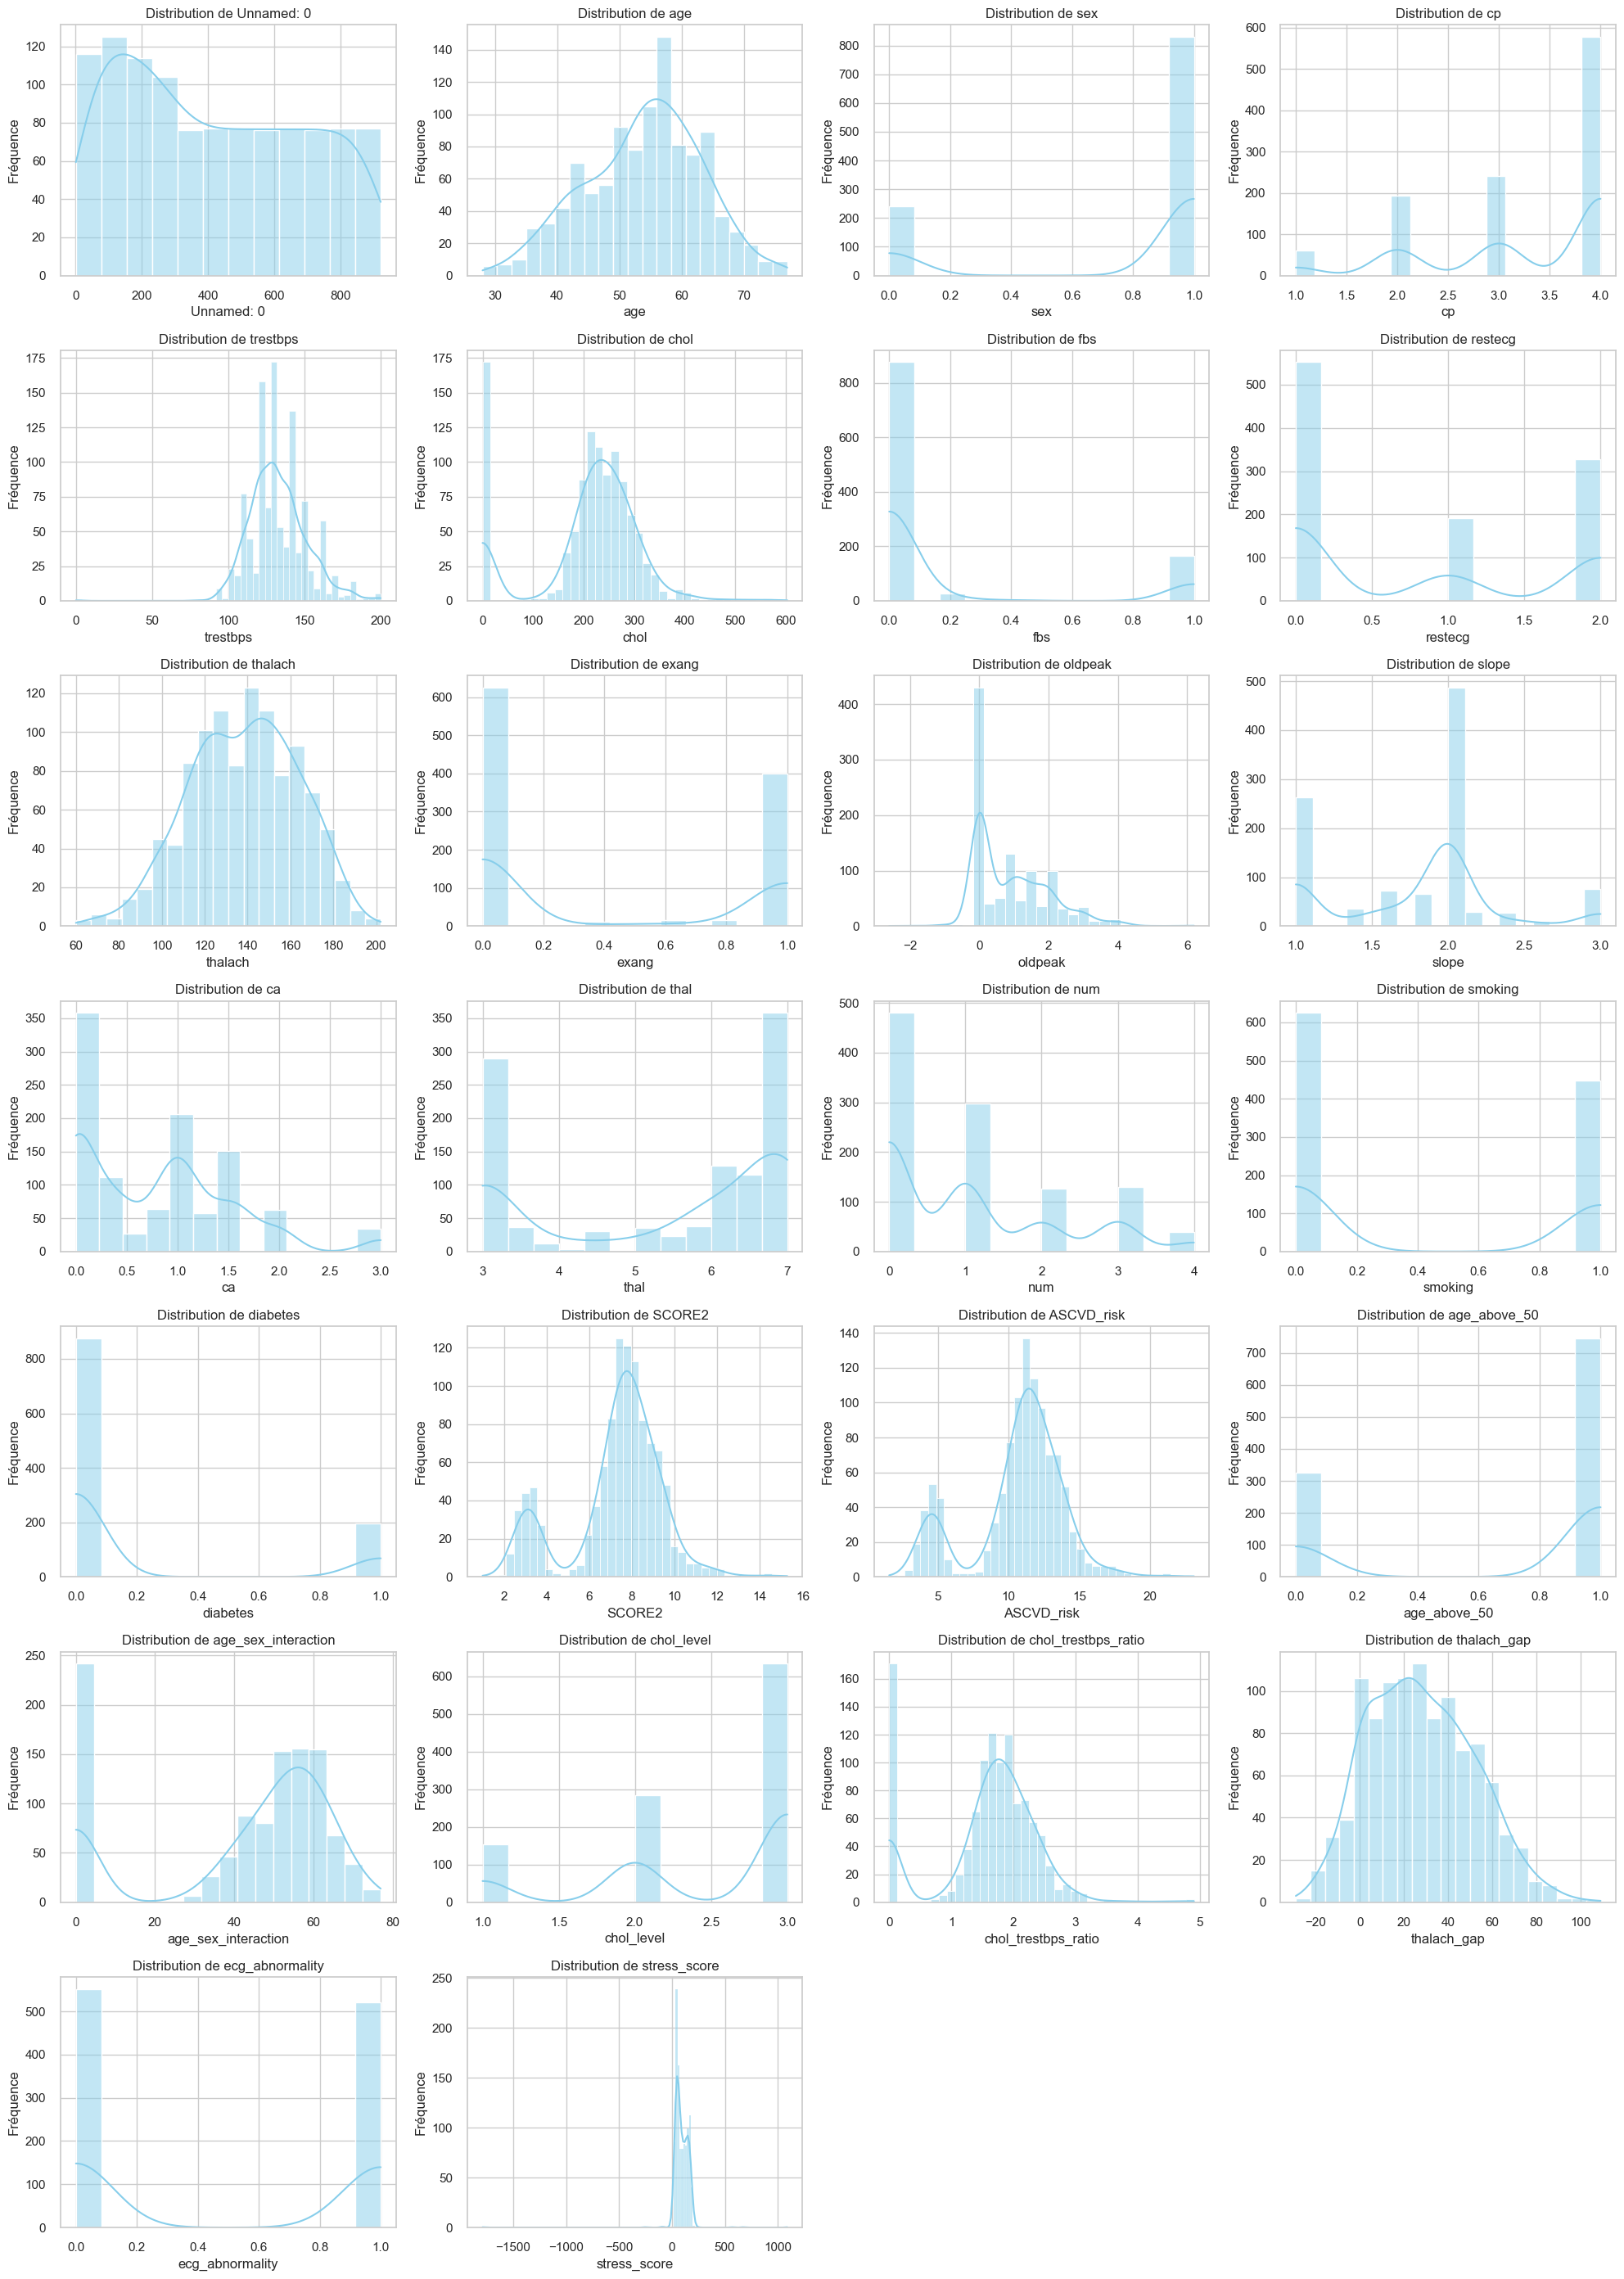

In [ ]:
# Configurer le style de visualisation
sns.set(style="whitegrid")

# Créer une grille de sous-plots pour afficher les distributions
num_columns = df_processed.shape[1]
num_rows = (num_columns + 3) // 4  # 4 graphiques par ligne
fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))
axes = axes.flatten()

# Afficher la distribution de chaque colonne
for i, col in enumerate(df_processed.columns):
    sns.histplot(df_processed[col], kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Fréquence")

# Supprimer les axes inutilisés s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

les données paraissent ok et pretes pour le training

# Modele developpement + export

In [ ]:
import numpy as np
import pandas as pd
import time
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Configure logging
logging.basicConfig(filename="model_performance.log", level=logging.INFO,
                    format="%(asctime)s - %(message)s")

# Load dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# List of models and parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'lbfgs']
    }),
    'SVM': (SVC(random_state=42), {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }),
    'KNeighbors': (KNeighborsClassifier(), {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__max_depth': [3, 5, 7]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.5],
        'clf__max_depth': [3, 5, 7]
    })
}

# Define metrics for cross-validation
metrics = {
    'accuracy': 'accuracy',
    'recall': 'recall_weighted',
    'precision': 'precision_weighted',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc_ovr'  # For multiclass classification
}
results = []

# Loop over each model with tqdm for progress tracking
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models"):
    try:
        logging.info(f"Starting model: {model_name}")
        start_time = time.time()

        # Pipeline with RobustScaler and the model
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Cross-validation and GridSearchCV setup
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=1, verbose=1)
        
        # Model training with GridSearchCV
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Cross-validation evaluation on training set
        cv_results = cross_validate(best_model, X_train, y_train, cv=skf, scoring=metrics)
        
        # Calculate average scores
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in metrics}
        scores['training_time'] = time.time() - start_time
        scores['model'] = model_name
        scores['best_params'] = grid_search.best_params_

        # Log results
        logging.info(f"Model {model_name} completed with scores: {scores}")
        results.append(scores)

    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Save performance results to CSV
performance_df = pd.DataFrame(results)
performance_df.to_csv("model_performance_summary.csv", index=False)
logging.info("All models evaluated, performance saved to model_performance_summary.csv")

# Selecting the best model based on accuracy (or other metric)
best_model_info = performance_df.loc[performance_df['accuracy'].idxmax()]
best_model_name = best_model_info['model']
best_params = best_model_info['best_params']

# Final training of the best model on the full training set
best_model_pipeline = Pipeline([
    ('clf', models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()}))
])

# Train the best model on the full training set
best_model_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set for a true hold-out performance measure
test_predictions = best_model_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')
test_roc_auc = roc_auc_score(y_test, best_model_pipeline.predict_proba(X_test), multi_class="ovr")

# Log test set performance
logging.info(f"Test set performance for {best_model_name}:")
logging.info(f"Accuracy: {test_accuracy}, Recall: {test_recall}, Precision: {test_precision}, F1: {test_f1}, ROC AUC: {test_roc_auc}")

# Save the best model with joblib and pickle
joblib.dump(best_model_pipeline, f"best_model_{best_model_name}.joblib")
with open(f"best_model_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Best model {best_model_name} saved as best_model_{best_model_name}.joblib and best_model_{best_model_name}.pkl")


Training models:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  14%|█▍        | 1/7 [00:01<00:08,  1.42s/it]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  29%|██▊       | 2/7 [00:03<00:10,  2.07s/it]

Training failed for model SVM: Pipeline has none of the following attributes: predict_proba.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  43%|████▎     | 3/7 [00:04<00:05,  1.40s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models:  57%|█████▋    | 4/7 [00:05<00:03,  1.13s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  71%|███████▏  | 5/7 [00:46<00:31, 15.65s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  86%|████████▌ | 6/7 [08:47<02:53, 173.83s/it]c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  w

Best model RandomForest saved as best_model_RandomForest.joblib and best_model_RandomForest.pkl


## on replace le contexte du benefique

2. Implement a Custom Scoring Function

Define a scoring function that calculates net benefits based on the formula provided:
Net Benefits=(TP×30000)−(FN×50000)−(FP×10000)
Net Benefits=(TP×30000)−(FN×50000)−(FP×10000)

In [ ]:
from sklearn.metrics import make_scorer, confusion_matrix

def net_benefit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)


In [ ]:
import numpy as np
import pandas as pd
import time
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Configure logging
logging.basicConfig(filename="model_performance.log", level=logging.INFO,
                    format="%(asctime)s - %(message)s")

# Custom scoring function for net benefits
def net_benefit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] == 2:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0  # Initialize variables if multiclass confusion matrix
        for i in range(len(cm)):
            tp += cm[i, i]
            fn += sum(cm[i, :]) - cm[i, i]
            fp += sum(cm[:, i]) - cm[i, i]
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)

# Load dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models and hyperparameter grids for the top 3 models
models = {
    'RandomForest': (RandomForestClassifier(random_state=42, class_weight="balanced"), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__max_depth': [3, 5, 7],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__max_depth': [3, 5, 7],
        'clf__min_child_weight': [1, 3, 5],
        'clf__gamma': [0, 0.1, 0.2]
    })
}

# Define evaluation metrics
metrics = ['accuracy', 'recall_weighted', 'precision_weighted', 'f1_weighted', 'roc_auc_ovr']
results = []

# Loop over each model with tqdm for progress tracking
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models"):
    try:
        logging.info(f"Starting model: {model_name}")
        start_time = time.time()

        # Pipeline with RobustScaler and the model
        pipeline = Pipeline([
            ('clf', model)
        ])
        
        # Cross-validation and GridSearchCV setup
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=net_benefit_scorer, n_jobs=1, verbose=1)
        
        # Model training with GridSearchCV
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Cross-validation evaluation on training set
        cv_results = cross_validate(best_model, X_train, y_train, cv=skf, scoring=metrics, n_jobs=1)
        
        # Calculate average scores
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in metrics}
        scores['net_benefit'] = net_benefit(y_train, best_model.predict(X_train))  # Explicitly calculate net benefit
        scores['training_time'] = time.time() - start_time
        scores['model'] = model_name
        scores['best_params'] = grid_search.best_params_

        # Log results
        logging.info(f"Model {model_name} completed with scores: {scores}")
        results.append(scores)

    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Save performance results to CSV
performance_df = pd.DataFrame(results)
performance_df.to_csv("model_performance_summary.csv", index=False)
logging.info("All models evaluated, performance saved to model_performance_summary.csv")

# Selecting the best model based on net benefit
try:
    best_model_info = performance_df.loc[performance_df['net_benefit'].idxmax()]
    best_model_name = best_model_info['model']
    best_params = best_model_info['best_params']
except KeyError:
    print("Error: 'net_benefit' not found in performance data. Check scoring and metrics.")
    logging.error("Error: 'net_benefit' not found in performance data.")

# Final training of the best model on the full training set
best_model_pipeline = Pipeline([
    ('clf', models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()}))
])

# Train the best model on the full training set
best_model_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set for a true hold-out performance measure
test_predictions = best_model_pipeline.predict(X_test)
test_net_benefit = net_benefit(y_test, test_predictions)

# Log test set performance
logging.info(f"Test set net benefit for {best_model_name}: {test_net_benefit}")
print(f"Test set net benefit for {best_model_name}: {test_net_benefit}")

# Save the best model with joblib and pickle
joblib.dump(best_model_pipeline, f"best_model_benef_{best_model_name}.joblib")
with open(f"best_model_benef_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Best model {best_model_name} saved as best_model_{best_model_name}.joblib and best_model_{best_model_name}.pkl")


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Training models:  33%|███▎      | 1/3 [07:11<14:22, 431.08s/it]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  if not keep_mask:
Training models:  67%|██████▋   | 2/3 [42:04<23:29, 1409.04s/it]c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  w

Test set net benefit for GradientBoosting: 420000
Best model GradientBoosting saved as best_model_GradientBoosting.joblib and best_model_GradientBoosting.pkl


# Testing best model on test and get metrcis

In [ ]:
import numpy as np
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import lime
import lime.lime_tabular
import shap

# Load the dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data again for evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load the best model
try:
    model = joblib.load("best_model_benef_GradientBoosting.joblib")
except:
    with open("best_model_GradientBoosting.pkl", "rb") as f:
        model = pickle.load(f)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_net_benefit = net_benefit(y_test, test_predictions)

print(f"Test set net benefit for GradientBoosting: {test_net_benefit}")

# Calculate performance metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")

print(f"Test set metrics:\nAccuracy: {test_accuracy}\nRecall: {test_recall}\nPrecision: {test_precision}\nF1 Score: {test_f1}\nROC AUC: {test_roc_auc}")


Test set net benefit for GradientBoosting: 420000
Test set metrics:
Accuracy: 0.6883720930232559
Recall: 0.6883720930232559
Precision: 0.6812357564714163
F1 Score: 0.6783706189002068
ROC AUC: 0.8902895830912726


#### Interpretation

1. Net Benefit: 420,000

    The net benefit metric is a custom evaluation measure you implemented based on specific business considerations. In your case, it factors in:
        The reward for correctly predicting positive cases (True Positives).
        The costs associated with False Negatives (missed positive cases) and False Positives (incorrectly predicted positive cases).
    A positive value (420,000) indicates that, overall, the model's predictions lead to a net benefit when applied to the test data. This means the value generated by correct predictions outweighs the losses from incorrect predictions.
    Interpretation: The model is financially beneficial according to your cost-benefit framework.

2. Accuracy: 0.688

    Accuracy measures the proportion of correct predictions (both True Positives and True Negatives) out of the total number of samples.
    With an accuracy of 68.8%, the model is correctly predicting around 69 out of 100 cases.
    Interpretation: While this is a good baseline measure, it may not be sufficient for an imbalanced dataset or a high-risk medical application, where False Negatives are more costly.

3. Recall (Weighted): 0.688

    Recall, also known as sensitivity, measures the proportion of actual positive cases that were correctly identified by the model.
    A recall of 68.8% means the model correctly identifies about 69% of all true positive cases.
    Interpretation: This is a critical metric if missing positive cases is costly (e.g., missing a heart disease diagnosis). In your context, you want a high recall to minimize False Negatives.

4. Precision (Weighted): 0.681

    Precision measures the proportion of positive predictions that were actually correct.
    With a precision of 68.1%, about 68% of the positive predictions made by the model are true positives.
    Interpretation: This metric is important when the cost of a False Positive (incorrectly predicting a positive case) is high. A lower precision could indicate many False Positives, which may not be desirable.

5. F1 Score (Weighted): 0.679

    The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both.
    An F1 score of 67.9% indicates the model has a balanced trade-off between precision and recall.
    Interpretation: This is useful when you want a balance between the cost of False Positives and False Negatives. Given your context, this score shows a reasonable but not exceptional balance.

6. ROC AUC (OVR): 0.890

    ROC AUC (Receiver Operating Characteristic - Area Under Curve) measures the model's ability to distinguish between the classes.
    An AUC of 0.890 suggests that the model has good discriminatory power. The closer the AUC is to 1, the better the model is at distinguishing positive cases from negative ones.
    Interpretation: This is a strong performance metric, indicating that the model is effective at ranking positive cases higher than negative ones.

Overall Interpretation

    Your model shows solid performance, particularly in terms of ROC AUC and net benefit. The high ROC AUC suggests that the model is good at differentiating between the classes.
    The net benefit metric shows that the model's decisions are financially advantageous based on your specified cost-benefit analysis.
    However, the accuracy, recall, and precision could be improved, especially if you aim to minimize False Negatives (which might be critical in medical applications).
    You might want to further tune the model or consider ensemble methods to boost these metrics slightly higher, especially if False Negatives are costly.

### Confusion Matrix

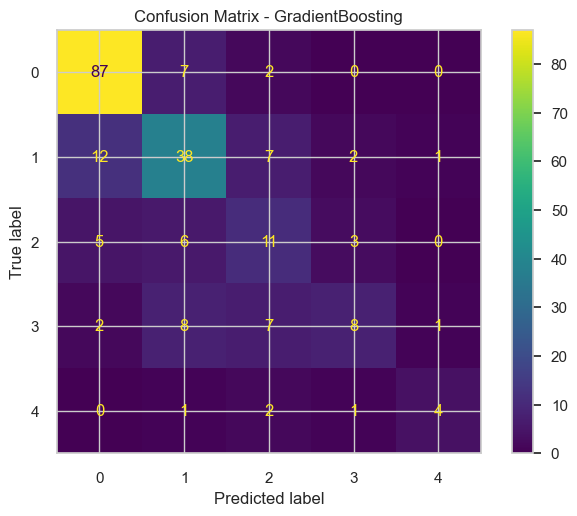

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - GradientBoosting")
plt.show()


The confusion matrix shows that the model is performing reasonably well on certain classes (e.g., class 0) but struggles with others (e.g., classes 2, 3, and 4).
The misclassification is significant for some classes, indicating a possible class imbalance problem, as some classes have fewer instances. This is evident in the small numbers for certain true labels (e.g., classes 3 and 4).
To address this, we can apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes during training.

### LIME

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=np.unique(y).astype(str),
    mode='classification'
)

# Pick a random sample from the test set
i = np.random.randint(0, X_test.shape[0])
sample = X_test.iloc[i].values.reshape(1, -1)
exp = explainer.explain_instance(sample[0], model.predict_proba, num_features=10)
exp.show_in_notebook()


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


THe Lime plot shows feature importance for a specific prediction. Key features like Unnamed: 0, cp (chest pain), and slope appear influential, but Unnamed: 0 should not be an important feature since it likely represents an index or ID.
Features such as cp, slope, stress_score, and chol_trestbps_ratio seem to be driving the predictions, which is expected based on the domain (heart disease prediction). However, the inclusion of irrelevant features like Unnamed: 0 suggests that feature selection needs to be refined.

### sHAP

In [ ]:
explainer = shap.TreeExplainer(model.named_steps['clf'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!

### Retraining New Model 

In [ ]:
import numpy as np
import pandas as pd
import time
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier,
                               ExtraTreesClassifier, HistGradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, roc_auc_score, make_scorer, confusion_matrix)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Configure logging
logging.basicConfig(filename="model_performance_smoted.log", level=logging.INFO, format="%(asctime)s - %(message)s")

# Custom scoring function for net benefits
def net_benefit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = 0, 0, 0, 0
    for i in range(len(cm)):
        tp += cm[i, i]
        fn += sum(cm[i, :]) - cm[i, i]
        fp += sum(cm[:, i]) - cm[i, i]
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)

# Load and preprocess the dataset
df_processed = pd.read_csv("standarded_data_featureseng.csv")
df_processed = df_processed.drop(columns=["Unnamed: 0"])
X = df_processed.drop(columns=["num"])
y = df_processed["num"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Define classifiers and parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'lbfgs']
    }),
    'KNeighbors': (KNeighborsClassifier(), {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    }),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    }),
    'LightGBM': (LGBMClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [-1, 10, 20]
    }),
}

# Initialize metrics and results
metrics = ['accuracy', 'recall_weighted', 'precision_weighted', 'f1_weighted', 'roc_auc_ovr']
results = []

# Loop through models and perform GridSearchCV
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models"):
    try:
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('clf', model)
        ])
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=net_benefit_scorer, n_jobs=1, verbose=1)
        
        # Train model with GridSearchCV
        grid_search.fit(X_train_sm, y_train_sm)
        best_model = grid_search.best_estimator_
        
        # Evaluate on test set
        test_predictions = best_model.predict(X_test)
        net_benefit = net_benefit_scorer(best_model, X_test, y_test)
        recall = recall_score(y_test, test_predictions, average='weighted')

        # Log and store results
        scores = {
            'model': model_name,
            'net_benefit': net_benefit,
            'recall': recall,
            'best_params': grid_search.best_params_
        }
        results.append(scores)
        logging.info(f"Model {model_name} completed with scores: {scores}")
    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Select the best model based on net benefit and recall
results_df = results_df.sort_values(by=['net_benefit', 'recall'], ascending=[False, False])
best_model_info = results_df.iloc[0]
best_model_name = best_model_info['model']
best_params = best_model_info['best_params']

print(f"Best model: {best_model_name}")
print(f"Net Benefit: {best_model_info['net_benefit']}")
print(f"Recall: {best_model_info['recall']}")
print(f"Best Parameters: {best_params}")

# Final training of the best model
final_model = models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', final_model)
])

# Train on the full training data
final_pipeline.fit(X_train_sm, y_train_sm)

# Save the best model
joblib.dump(final_pipeline, f"best_model_{best_model_name}.joblib")
with open(f"best_model_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(final_pipeline, f)

print(f"Best model {best_model_name} saved as best_model_{best_model_name}.joblib and best_model_{best_model_name}.pkl")


Training models:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\yskon\anaconda3.2\envs\heart_disease_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Training models:  29%|██▊       | 2/7 [00:05<00:12,  2.54s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Training models:  43%|████▎     | 3/7 [00:07<00:08,  2.18s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  57%|█████▋    | 4/7 [04:14<04:56, 98.71s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  71%|███████▏  | 5/7 [38:16<26:39, 799.51s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training models:  86%|████████▌ | 6/7 [39:41<09:16, 556.46s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 24
[LightGBM] [Info] Start training from score -1.610089
[LightGBM] [Info] Start training from score -1.610089
[LightGBM] [Info] Start training from score -1.610089
[LightGBM] [Info] Start training from score -1.610089
[LightGBM] [Info] Start training from score -1.606837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 24
[LightGBM] [Info] Start training from score -1.610089
[LightGBM] [Info] Start training from 

Training models: 100%|██████████| 7/7 [41:10<00:00, 352.91s/it]


Best model: RandomForest
Net Benefit: 330000
Recall: 0.6837209302325581
Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best model RandomForest saved as best_model_RandomForest.joblib and best_model_RandomForest.pkl


In [ ]:
import numpy as np
import pandas as pd
import logging
import joblib
import pickle
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Configuration de logging
logging.basicConfig(filename="model_optimization_no_smote.log", level=logging.INFO, format="%(asctime)s - %(message)s")

# Fonction pour maximiser les bénéfices nets
def net_benefit(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp * 30000) - (fn * 50000) - (fp * 10000)

# Scorer personnalisé pour GridSearchCV
net_benefit_scorer = make_scorer(net_benefit, greater_is_better=True)

# Chargement et préparation des données
df = pd.read_csv("standarded_data_featureseng.csv").drop(columns=["Unnamed: 0"])
X = df.drop(columns=["num"])
y = df["num"].apply(lambda x: 1 if x != 0 else 0)  # Transformation de la cible

# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Définition des modèles et grilles de paramètres
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'clf__C': [0.1, 1,5, 10],
        'clf__solver': ['liblinear', 'lbfgs']
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [100,150, 200,250],
        'clf__max_depth': [None,5, 10, 15],
        'clf__min_samples_split': [2,4, 6]
    }),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'clf__n_estimators': [50, 100,150],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 5]
    }),
    'LightGBM': (LGBMClassifier(random_state=42), {
        'clf__n_estimators': [50,75, 100,125],
        'clf__learning_rate': [0.01,0.05, 0.1],
        'clf__max_depth': [-1,5,10]
    }),
}

# Initialiser les résultats
results = []

# Entraîner et optimiser les modèles
for model_name, (model, param_grid) in tqdm(models.items(), desc="Training models without SMOTE"):
    try:
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('clf', model)
        ])
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=net_benefit_scorer, n_jobs=1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Optimisation du seuil pour maximiser les bénéfices nets
        y_prob = best_model.predict_proba(X_test)[:, 1]
        best_threshold = 0
        best_net_benefit = float('-inf')
        thresholds = np.linspace(0, 1, 101)

        # Tester différents seuils
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            net_benefit_value = net_benefit(y_test, y_pred)
            if net_benefit_value > best_net_benefit:
                best_net_benefit = net_benefit_value
                best_threshold = threshold

        # Évaluation sur le test set avec le seuil optimal
        y_pred_optimal = (y_prob >= best_threshold).astype(int)
        recall = recall_score(y_test, y_pred_optimal)

        # Sauvegarder les résultats
        scores = {
            'model': model_name,
            'net_benefit': best_net_benefit,
            'recall': recall,
            'best_threshold': best_threshold,
            'best_params': grid_search.best_params_
        }
        results.append(scores)
        logging.info(f"Model {model_name} completed with scores: {scores}")

    except Exception as e:
        logging.error(f"Training failed for model {model_name}: {e}")
        print(f"Training failed for model {model_name}: {e}")

# Création du DataFrame des résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['net_benefit', 'recall'], ascending=[False, False])
best_model_info = results_df.iloc[0]
best_model_name = best_model_info['model']
best_threshold = best_model_info['best_threshold']
best_params = best_model_info['best_params']

# Affichage des meilleurs résultats
print(f"Best model: {best_model_name}")
print(f"Net Benefit: {best_model_info['net_benefit']}")
print(f"Recall: {best_model_info['recall']}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Parameters: {best_params}")

# Réentraînement du meilleur modèle avec les paramètres optimaux
final_model = models[best_model_name][0].set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', final_model)
])
final_pipeline.fit(X_train, y_train)

# Sauvegarder le modèle final
joblib.dump(final_pipeline, f"best_model__binary{best_model_name}.joblib")
with open(f"best_model_{best_model_name}.pkl", 'wb') as f:
    pickle.dump(final_pipeline, f)

print(f"Best model {best_model_name} saved with threshold {best_threshold:.2f}.")


Training models without SMOTE:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Training models without SMOTE:  25%|██▌       | 1/4 [00:00<00:02,  1.37it/s]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Training models without SMOTE:  50%|█████     | 2/4 [01:01<01:11, 35.93s/it]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Training models without SMOTE:  75%|███████▌  | 3/4 [01:06<00:22, 22.08s/it]

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 378, number of negative: 307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 685, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551825 -> initscore=0.208046
[LightGBM] [Info] Start training from score 0.208046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Training models without SMOTE: 100%|██████████| 4/4 [01:17<00:00, 19.32s/it]


Best model: RandomForest
Net Benefit: 3290000
Recall: 1.0
Best Threshold: 0.22
Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 4, 'clf__n_estimators': 150}
Best model RandomForest saved with threshold 0.22.


In [15]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Charger le meilleur modèle sauvegardé
best_model = joblib.load(f"best_model_{best_model_name}.joblib")

# Prédire les probabilités sur l'ensemble de test
y_prob_test = best_model.predict_proba(X_test)[:, 1]

# Appliquer le seuil optimal pour les prédictions
y_pred_test = (y_prob_test >= best_threshold).astype(int)

# Calcul des métriques sur l'ensemble de test
net_benefit_test = net_benefit(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_prob_test)

# Afficher les résultats
print("\n--- Test Set Evaluation ---")
print(f"Net Benefit: {net_benefit_test}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"ROC AUC: {roc_auc_test:.4f}")

# Logger les résultats
logging.info(f"Test Set Evaluation - Net Benefit: {net_benefit_test}, "
             f"Accuracy: {accuracy_test:.4f}, Recall: {recall_test:.4f}, "
             f"Precision: {precision_test:.4f}, F1 Score: {f1_test:.4f}, "
             f"ROC AUC: {roc_auc_test:.4f}")



--- Test Set Evaluation ---
Net Benefit: 3290000
Accuracy: 0.8698
Recall: 1.0000
Precision: 0.8095
F1 Score: 0.8947
ROC AUC: 0.9448
